### Wrangling and EDA

Getting rid of duplicate entries, by id of post.

In [15]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
pd.set_option("display.max_columns", 45)

In [17]:
data = pd.read_csv('scraped\data\one_dataframe_relevant_features_no_cleaning_with_location.csv')

In [19]:
# Binary search looking for duplicates.
data.set_index('id', inplace=True)

Keeping only the first ad:

In [20]:
data = data.loc[~data.index.duplicated()]

In [21]:
len(set(data['vin']))

35893

In [22]:
 len(data['vin'])

35938

There are a lot of duplicate ads, which is expected as my search areas overlap. Not so many different ads for the same car, though.

Keeping only the first VIN:

In [23]:
data = data.loc[~data['vin'].duplicated()]

Checking for nulls

In [25]:
data.isnull().values.sum()

40975

In [26]:
for col in data.columns:
    if data[col].isnull().values.sum() > 0:
        print(col, ":", data[col].isnull().values.sum(), 'missing values.')

subModel : 35893 missing values.
badge : 5082 missing values.


The only columns that have missing values are subModel and badge. Because many cars don't have submodels, I will get rid of this column. For badge, I will remove this one too because it is based on the other features and will cause problems of multicollinearity.

In [27]:
data.drop('subModel', axis = 1, inplace = True)
data.drop('badge', axis = 1, inplace = True)

### Where are the cars?

In [28]:
%%HTML
<iframe seamless frameborder="0" src="https://public.tableau.com/views/Capstone2EDA/DualMapDash?:embed=yes&:device=desktop&:display_count=y&publish=yes&:origin=viz_share_link&:showVizHome=no" width = '950' height = '610'></iframe>

The map visualization above shows circles, corresponding to the locations of cars sold as well as amount of cars sold (by the size of the circle). The states are also colored to be a darker shade of blue for states where relatively more cars were sold. 

A few interesting patterns emerge from this viz. The first is that a lot of cars are sold in California and Texas. In these states there are big hubs of activity centered around the large cities such as San Francisco, Los Angeles, and Dallas. Interestingly, outside of those hubs, there is not too much activity. On the East Coast on the other hand, it appears as though the hubs aren't as large, and the activity is spread out more evenly across smaller communities. This is shown by the fact that on the East coast, broadly speaking, the dots are smaller but more spread out, whereas on the West Coast, the dots are closer together and larger in size.

In this report, there aren't ads that come from North Dakota, South Dakota, or Nebraska on the continental US; and Hawaii and Alaska are not represented either.

Given this broad overview of the data at hand, I will dive into the deeper analysis, shown below.

In [29]:
%%HTML

<iframe seamless frameborder="0" src="https://public.tableau.com/views/Capstone2EDA/DimensionToggleSheet?:embed=yes&:device=desktop&:display_count=y&publish=yes&:origin=viz_share_link&:showVizHome=no" width = '950' height = '610'></iframe>

The main takeaway I have from the above visualiazation is that the data are not qually distributed among the different dimensions, meaning for example there are more Kias than Nissans. This means that down the line, I will have to pay closer attention to models that perform well when data is equally distributed.

#### Exploration of each numerical value

In [30]:
%%HTML

<iframe seamless frameborder="0" src="https://public.tableau.com/views/Capstone2EDA/PriceMapDash?:embed=yes&:device=desktop&:display_count=y&publish=yes&:origin=viz_share_link&:showVizHome=no" width = '950' height = '610'></iframe>

This visualization makes it clear that the highest median price for a car is in the North-West (as deliminated on the map above) and the lowest in the South-West. The range of values is not too great, however. The minimum is 23,900 USD and the maximum is 25,881 USD. It's important to note, however, the differences in the number of car listings in each region. This may play a role in skewing the data slightly. But, as mentioned before, it's clear that the diffrences between the median prices of cars in each region are not great, so I doubt this will play a role in modeling.

In [31]:
data.columns

Index(['city', 'state', 'latitude', 'longitude', 'dealerReviewRating',
       'dealerReviewCount', 'city.1', 'state.1', 'vin', 'year', 'make',
       'model', 'trim', 'subTrim', 'topOptions', 'newTopOptions', 'mileage',
       'listPrice', 'currentPrice', 'exteriorColor', 'interiorColor', 'engine',
       'displacement', 'drivetype', 'transmission', 'fuel', 'mpgCity',
       'mpgHighway', 'bodytype', 'vehicleCondition', 'cabType', 'bedLength',
       'imageCount', 'oneOwner', 'noAccidents', 'serviceRecords',
       'personalUse'],
      dtype='object')

In [32]:
sum(data.listPrice != data.currentPrice)

0

Will be looking at currentPrice as the label. There are two: listPrice and currentPrice. The website allws its users to change the list price after posting the ad. This way, if there is a price change, the new one will be more reflective of the intended value of the car. Plus there aren't any differences.

In [33]:
cts_features = ['dealerReviewCount', 'year',  'mileage', 'mpgCity', 
                'mpgHighway', 'imageCount', 'currentPrice']

Excluding: 'dealerReviewRating', 'topOptions', 'newTopOptions', because it's not very continuous.

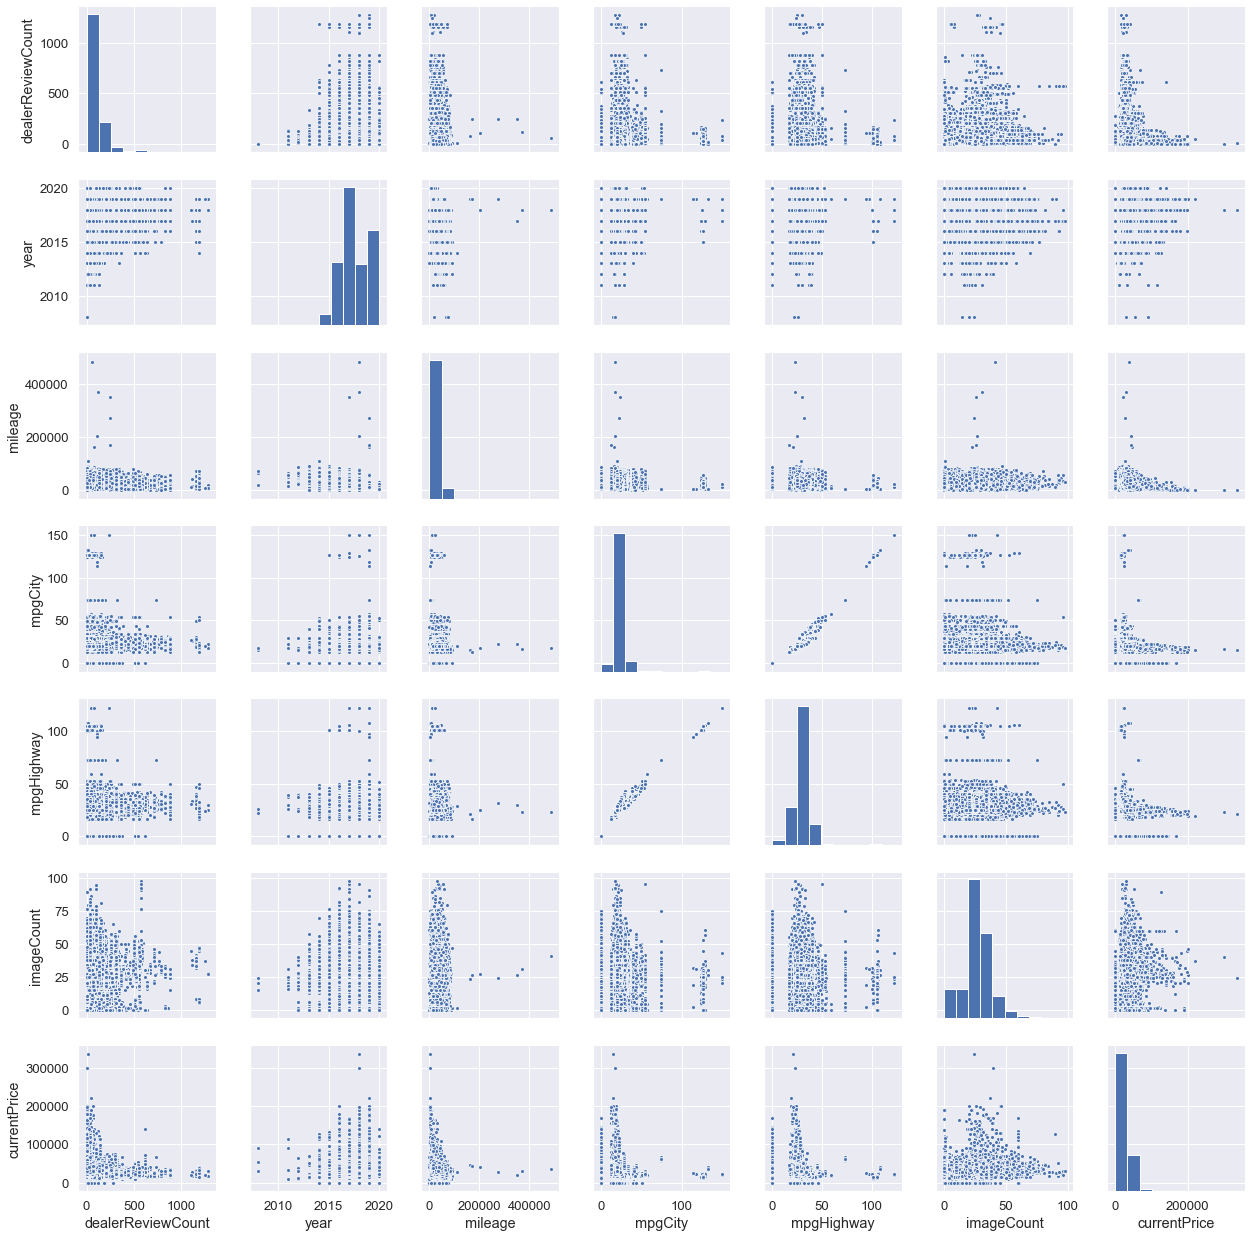

In [34]:
sns.set(font_scale=1.2)
# Basic correlogram
ax = sns.pairplot(data[cts_features],plot_kws={"s": 15})
ax.fig.savefig('images/1.pre_cleaning_corr_scatter.png', dpi=400)

This plot is very large and overwhelming, but I'm only really looking for multicollinearity between features that may mess up a lot of future modeling. There looks to be a high correlation between mpdCity and mpgHighway, somthing that I will have to account for in the future. It's possible that keeping just one will yield better results.

A few other things stand out too. For example There is a cluster of cars on the high end of mgpCity and mpgHighway. These are likely hybrid cars that will have to be accounted for, as they are outliers. Analogously, there are cars that have 0 mgpCity and 0 mpgHighway readings. At first glance, these are likely electric cars, but I will doublecheck.


Mileage, currentPrice, and dealerReviewCount also have pretty heavy outliers that may need to be accounted for.



#### mpgCity and mpgHighway 0

In [35]:
sum(data['mpgHighway'] == 0)

813

In [36]:
sum(data['mpgCity'] == 0)

813

There is the same amout of each of these, telling me they are the same cars, likely.

In [37]:
sum(data[data['mpgHighway'] == 0].vin != data[data['mpgCity'] == 0].vin)

0

The code above confirms that they are the same cars

In [38]:
set(data[data['mpgHighway'] == 0].engine)

{'2 Cyl', '4 Cyl', '5 Cyl', '6 Cyl', '8 Cyl', 'Electric'}

Not only electric cars are in this list. Thus, the mpg readings for some of these cars were input incorrectly.

### Imputing mpg

**********

What are the cars that o for mpgCity and mpgHighway

In [39]:
no_mpg_gas = data[(data['mpgHighway'] == 0) & (data['engine'] != 'Electric')][['make', 'model', 'bodytype', 'year']]

In [41]:
# Imputing missing mileage through looking at other similar cars
manually_add_mpg = []

for index, row in tqdm(no_mpg_gas.iterrows()):
    # Looking for other cars that have an mpg reading
    x1 = data[(data['make'] == row['make']) & (data['bodytype'] == row['bodytype']) & 
            (data['model'] == row['model']) & (data['year'] == row['year']) & (data['mpgCity'] != 0)]
    # broadering the search to not include year
    x2 = data[(data['make'] == row['make']) & (data['bodytype'] == row['bodytype']) & 
            (data['model'] == row['model']) &(data['mpgCity'] != 0)]
    # broadering the search to not include model
    x3 = data[(data['make'] == row['make']) & (data['bodytype'] == row['bodytype']) &
            (data['mpgCity'] != 0)]
    # at this point, manual input is required
    
    # Checking the above conditions and imputing if met
    if len(x1) != 0:
        data.at[index,'mpgHighway'] = x1.iloc[0,]['mpgHighway']
        data.at[index,'mpgCity'] = x1.iloc[0,]['mpgCity']
        
    elif len(x2) != 0:
        data.at[index,'mpgHighway'] = x2.iloc[0,]['mpgHighway']
        data.at[index,'mpgCity'] = x2.iloc[0,]['mpgCity']
        
    elif len(x3) != 0:
        data.at[index,'mpgHighway'] = x3.iloc[0,]['mpgHighway']
        data.at[index,'mpgCity'] = x3.iloc[0,]['mpgCity']
        
    # if not met, adding to a list to be imputed manually
    else:
        manually_add_mpg.append(row)
        

787it [00:19, 40.31it/s]


In [ ]:
manually_add_mpg = pd.DataFrame(manually_add_mpg)

In [43]:
# Manually adding the rest from the internet

data.loc['19asdaeefase4ZDMfw238s9dfh04', ['mpgCity', 'mpgHighway']] = (21, 22)

data.loc['11asdaeefaseasdffwwwxzsswh04', ['mpgCity', 'mpgHighway']] = (21, 22)

data.loc['232sdfscvre34ZDMfw238s9dfh04', ['mpgCity', 'mpgHighway']] = (25, 25)

data.loc['1234gs3fsdse4Zsdfg3g8sfdfasd', ['mpgCity', 'mpgHighway']] = (10.4, 10.4)

data.loc['12o3jfos2ase4ZDMfw238sasdf24', ['mpgCity', 'mpgHighway']] = (10.4, 10.4)

data.loc['19as314kjsdlfi2dkks28s9dfh04', ['mpgCity', 'mpgHighway']] = (10.4, 10.4)

Checking to see if this worked.

In [44]:
data[(data['mpgHighway'] == 0) & (data['engine'] != 'Electric')][['make', 'model', 'bodytype', 'year']]

,make,model,bodytype,year
id,,,,


It did.

***

### currentPrice == 0

This, I will likely do with a machine learning method. For now I will remove it

In [ ]:
len(data['currentPrice'] == 0)

There are only around 200 of these rows, so I will remove them. I will use them later on for testing of the data pipeline in my webapp, and see if the process I set up works. I'm doing this to stay as conservative as possible, while still maintaining as much data as I possibly can.

In [47]:
data = data.drop(data[data['currentPrice'] == 0].index)

### Removing obvious outliers

In [53]:
data = data.drop(data[data.mileage>150000].index)

In [54]:
data = data.drop(data[data.currentPrice>201000].index)

There are only 10 cars in the above categories. These points are really influential because they are so far out from the rest. I will remove them because the accuracy of the model will improve drastically. This is something I will check though, especially with the more 'black box' ML methods such as XGBoost or neural nets, which might benefit from having them.

### Removing Small Cells

In this section, I remove some of the smallest cells in the data. By this I mean, any grouping or combination of groups that doesn't have many members. The reason for doing this is that small cell sizes tend to have a negative effect on a model's predictive abilities. As a rule of thumb, I will keep only the groups in which there are more than a dozen (12) members.

In [58]:
# list of categorical variables
cat_vars = ['city', 'state', 'make',
       'model', 'trim', 'subTrim', 'topOptions', 'newTopOptions', 'exteriorColor', 'interiorColor',
       'engine', 'displacement', 'drivetype', 'transmission', 'fuel',
       'bodytype', 'vehicleCondition', 'cabType',
       'bedLength', 'oneOwner', 'noAccidents', 'serviceRecords',
       'personalUse']

for feature in cat_vars:
    for i,p in data.groupby(feature).count().iloc[:,0].iteritems():
        if p < 12:
            data = data.drop(data[data[feature] == i].index)

In [59]:
for feature in cat_vars:
    for i,p in data.groupby(feature).count().iloc[:,0].iteritems():
        if p < 12:
            print('affirmative')

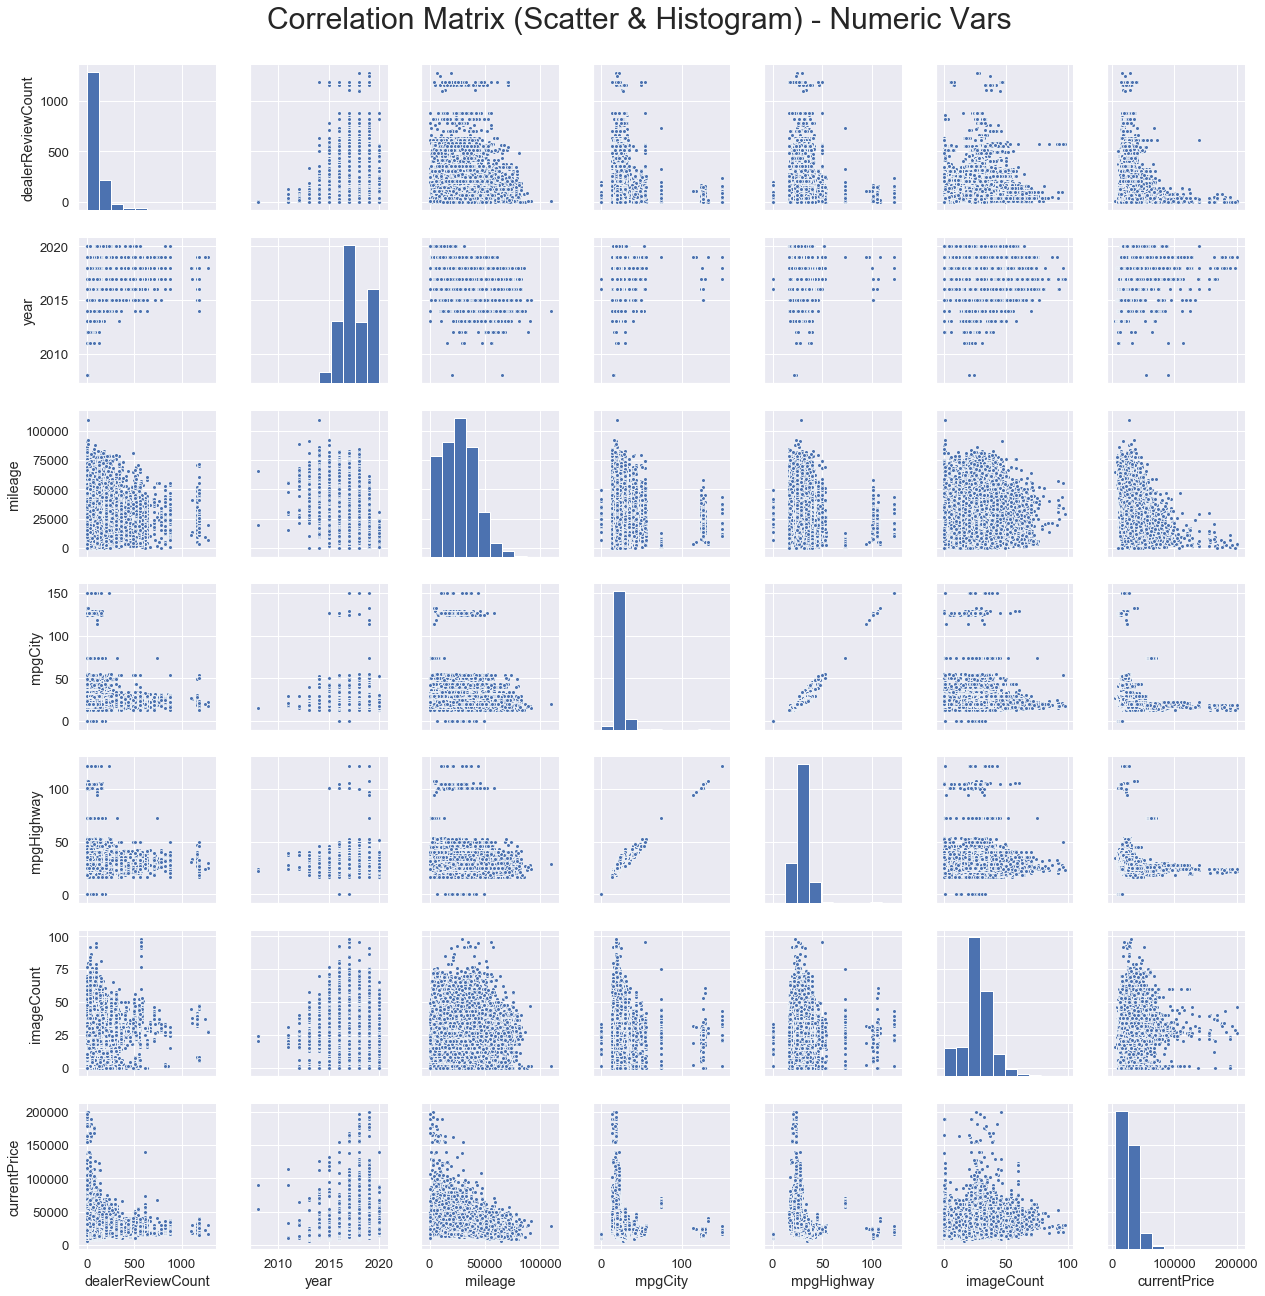

In [62]:
sns.set(font_scale=1.2)
ax = sns.pairplot(data[cts_features],plot_kws={"s": 15})
ax.fig.suptitle('Correlation Matrix (Scatter & Histogram) - Numeric Vars',fontsize=30, y = 1.03)
ax.fig.savefig('images/2.post_cleaning_corr_scatter.png', dpi=400)

Now with the big influential points removed, it's easier to look at the trends between the numeric variables. To start, there are some visible clusters of cars that may be easy to explain. For example mpgCity and mpgHighway have high end clusters, likely as a result of hybrid cars. There are also some cars from the year 2008, which might be influential. there also appears to be a cluster of dealerships with a very high amount of reviews, likely as a result of them being very good or very bad. 

In [63]:
np.mean(data[data['dealerReviewCount'] > 1000].dealerReviewRating)

5.0

Wow, upong closer view, all the dealers seem to only have a 5 star rating. They must be very good, have programs that incentivize giving them a 5 star review, like a rebate or discount, or are faking their reviews.

After a review of a sample of these dealerships, the reviews seemed genuine and the dealerships seemed to simply provide good service to their customers. It's also possible that they asked for reviews and had rebates, but that is unconfirmed.

Some other patterns stand out too. For example as mileage goes up, currentPrice seems to go down exponentially, somewhat expectedly. Note that there is a wide variation of prices at low mileages, but at high mileages, prices are exclusively low.

The other variables don't show very high correlations between each other and the target variable. This will be further investigated below with the same correlation plot, but one that better shows the correlations.

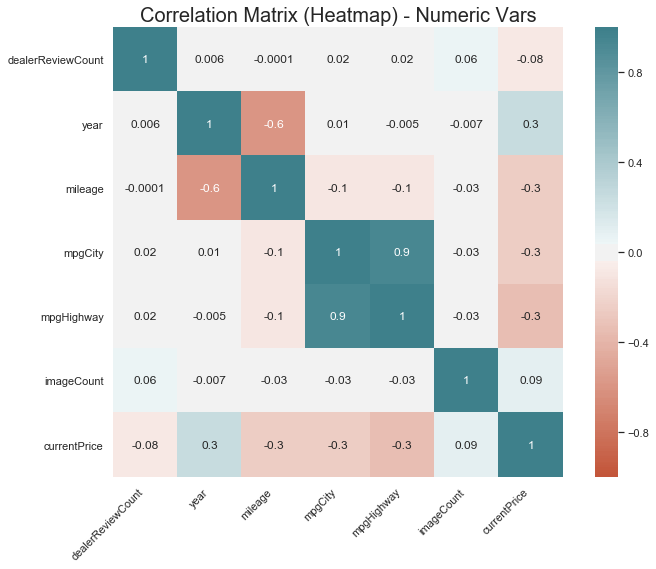

In [65]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
corr = data[cts_features].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 209, n=200),
    square=True,
    annot = True,
    fmt='.01g'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation Matrix (Heatmap) - Numeric Vars',fontsize=20)
#ax.axes.set_title("Title")
plt.savefig('images/3.post_cleaning_corr_heatmap.png', dpi=400)

The graph above confirms some of the patterns that emerged from the correlation matrix. mpgCity and mpgHighway have a correlation coefficient of 0.9 which can be devastating for some modeling techniques such as linear regression. Year and mileage are negatively correlated at -0.6, as expected. All other correlations are fairly small and are unlikely to cause trouble in modeling. There is also a relatively high positive correlation between year and currentPrice of 0.2, which makes sense, as newer cars would cost more.

### For Analysis of the categorical variables vs currentPrice, see the dashboard.

In [66]:
%%HTML
<iframe seamless frameborder="0" src="https://public.tableau.com/views/Capstone2EDA/DimensionToggleSheet3_1?:embed=yes&:device=desktop&:display_count=y&publish=yes&:origin=viz_share_link&:showVizHome=no" width = '950' height = '610'></iframe>